In [43]:
import numpy as np
import os
import glob
import math
import nibabel as nib
import cv2

from skimage import measure
from skimage import morphology
from scipy import ndimage
from scipy.spatial import ConvexHull


In [44]:
fname = './Images/IMG_0001.nii.gz'

nib_img = nib.load(fname)
bm_nib_img = nib.load('BodyMasks/BODYMASK_IMG_0001.nii.gz')
tk = nib_img.get_fdata()
bm_tk = bm_nib_img.get_fdata()

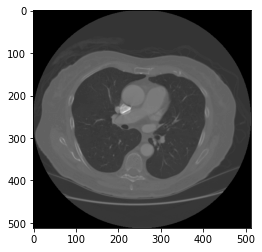

In [45]:
import matplotlib.pyplot as plt

plt.gray()

img = tk[:, :, 80]
bm_img = bm_tk[:, :, 80]
plt.imshow(img)

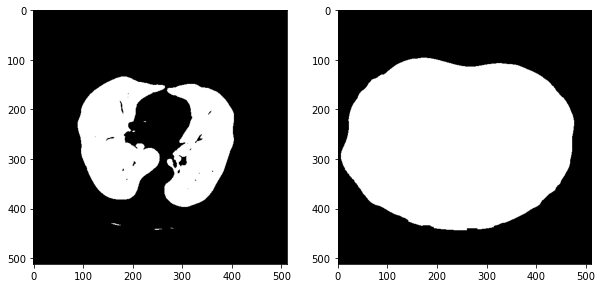

In [46]:
import cv2

_, binarized = cv2.threshold(tk, -320, 1, cv2.THRESH_BINARY_INV)
bm_seg = cv2.bitwise_and(binarized, bm_tk)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].imshow(bm_seg[:, :, 80])
axes[1].imshow(bm_tk[:, :, 80])


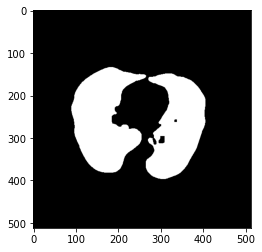

In [47]:
blurred = cv2.medianBlur(bm_seg.astype(np.float32), 5)
closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, np.ones((5, 5)))
plt.imshow(closed[:, :, 80])

In [48]:
def dice_coeff(A, B):
    intersection = np.sum(A * B)
    size_A = np.sum(A)
    size_B = np.sum(B)
    return (2. * intersection) / (size_A + size_B)

ref_nib = nib.load('ReferenceSegmentations/LUNGS_IMG_0001.nii.gz')
ref_ct = ref_nib.get_fdata()
selected = np.zeros(ref_ct.shape)
selected[ref_ct > 0] = 1

dice_coeff(closed, selected)

0.9785104234821285

In [49]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_dist(A, B):
    dA, _, _ = directed_hausdorff(A, B)
    dB, _, _ = directed_hausdorff(B, A)
    return max(dA, dB)

hausdorff_dist(closed, selected)

ValueError: Buffer has wrong number of dimensions (expected 2, got 3)

0.990381713940857

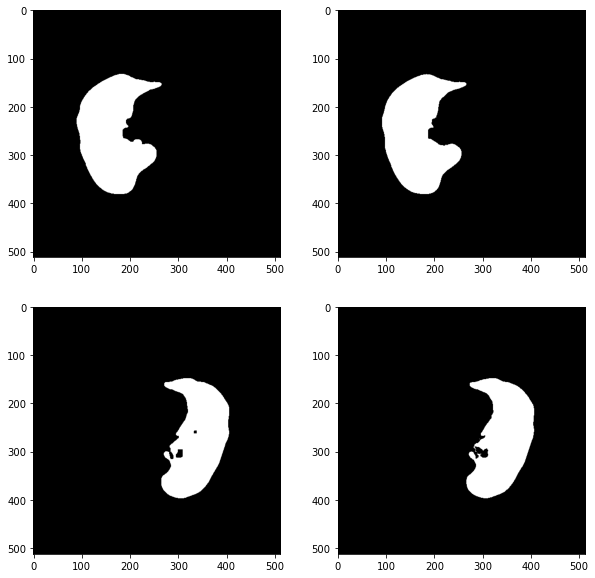

In [50]:
from skimage.segmentation import watershed

depth = closed.shape[2]
left_lungs = list()
right_lungs = list()
ref_left_lungs = list()
ref_right_lungs = list()

for i in range(depth):
    img = closed[:, :, i]
    ref_img = ref_ct[:, :, i]

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img.astype(np.uint8))
    segmented = watershed(img, labels, mask=labels)
    
    left_lung = np.zeros(segmented.shape)
    left_lung[segmented == 1] = 1
    left_lungs.append(left_lung)
    ref_left_lung = np.zeros(ref_img.shape)
    ref_left_lung[ref_img == 2] = 1
    ref_left_lungs.append(ref_left_lung)


    right_lung = np.zeros(segmented.shape)
    right_lung[segmented == 2] = 1
    right_lungs.append(right_lung)
    ref_right_lung = np.zeros(ref_img.shape)
    ref_right_lung[ref_img == 3] = 1
    ref_right_lungs.append(ref_right_lung)

left_lungs = np.dstack(left_lungs)
ref_left_lungs = np.dstack(ref_left_lungs)
right_lungs = np.dstack(right_lungs)
ref_right_lungs = np.dstack(ref_right_lungs)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0][0].imshow(left_lungs[:, :, 80])
axes[0][1].imshow(ref_left_lungs[:, :, 80])
axes[1][0].imshow(right_lungs[:, :, 80])
axes[1][1].imshow(ref_right_lungs[:, :, 80])

In [36]:
print(dice_coeff(ref_left_lungs, left_lungs))
print(dice_coeff(ref_right_lungs, right_lungs))

0.8427735836817787
0.7589997308469547


In [13]:
labels,_ = ndimage.label(foo)

if np.sum(labels) > 0:
    props = measure.regionprops(labels)
    ids,counts = np.unique(labels,return_counts=True)
    
    for i,c,regionProp in zip(ids[1:],counts[1:],props):   #bez tła

        voxels = np.where(labels==i)
        voxels = np.asarray(voxels)
        voxels = np.swapaxes(voxels,0,1)
        chull = ConvexHull(voxels,qhull_options = 'QJ')

        dum = np.zeros(labels.shape,dtype=np.float32)
        dum[labels==i] = 1
        verts, faces, _, _ = measure.marching_cubes(dum, 0.0)
        surf = measure.mesh_surface_area(verts, faces)

        print(fname,i, \
                surf, \
                math.pow(3*c/4/math.pi,1/3)/math.pow(surf/4/math.pi,1/2), \
                regionProp.area, \
                regionProp.inertia_tensor_eigvals[0], \
                regionProp.inertia_tensor_eigvals[1], \
                regionProp.inertia_tensor_eigvals[2], \
                regionProp.major_axis_length, regionProp.minor_axis_length, \
                regionProp.bbox_area, \
                regionProp.equivalent_diameter, \
                chull.volume,chull.area)


NameError: name 'foo' is not defined